# COGS 108 - Final Project 

# Overview

In this project, we look for the correlation between COVID-19 cases in the U.S and the negative sentiment towards Asian Americans on Twitter. To do this, we use snscrape to scrape tweets based on keywords and train an SVM using TF-IDF to classify tweets based on their sentiment. In our findings, we discovered no strong correlation between these two variables, and attribute this to various limitations such as model inaccuracy.

# Names

- Jeffrey Ha
- David Ma
- Mary Nguyen
- Jason Win
- Sidi Xu

# Research Question

What is the relationship between the rise of COVID-19 cases in the U.S. during the pandemic and the increase of negative sentiment, measured through tweet content and keywords, towards the Asian-American community on Twitter?

## Background and Prior Work

In the U.S, more than 10 million people have had confirmed cases of the coronavirus infections, with more than 240,000 deaths. 
During this ongoing pandemic, the COVID-19 outbreak has brought forward thousands of incidents pertaining to racism, discrimination, and violence against Asians. This is especially true in the United States where many hate crimes were committed towards Asian Americans. Ranging from racial slurs to being physically abused, it is most evident that there exists a connection between the COVID-19 virus and Asians due to the origins of the virus itself (Wuhan, China).

These incidents are even extended to social media. According to a Washington Post article “As the coronavirus spreads, so does online racism targeting Asians, new research shows” by Craig Timberg and Allyson Chiu, this acute hatred for Asian Americans have caused misinformation to widely spread on social media. Most evidently on Instagram where a post had called for the shooting of every Asian encountered in New York City’s Chinatown because of the belief that this is the only way to destroy the epidemic of COVID-19.

Seeing this increase in hatred, we wanted to focus our research question on whether social media has impacted the racialization of Asians in the United States. There was past research that was conducted on this topic. For example, the article by Frontier Media found that the more an individual believes news from their most used social media source is accurate, the more likely they are to believe that Asians pose a realistic threat to America, if not the entire world. Overall, we hope that our project is able to build upon past research and highlight how the racialization of COVID-19 has affected the Asian American community today.


References (include links):
- 1) https://www.frontiersin.org/articles/10.3389/fcomm.2020.00039/full
- 2) https://www.washingtonpost.com/technology/2020/04/08/coronavirus-spreads-so-does-online-racism-targeting-asians-new-research-shows/
- 3) https://www.npr.org/sections/health-shots/2020/09/01/816707182/map-tracking-the-spread-of-the-coronavirus-in-the-u-s

# Hypothesis


The rise in COVID-19 cases in the U.S. is correlated with an increase of negative sentiment towards the Asian American community. This is because we can see an increase of racially negative rhetoric on Twitter throughout the progression of COVID-19.

# Dataset(s)

- **Dataset Name:** CDC Data for Case Daily Trends - United States
- **Link to the dataset:** https://covid.cdc.gov/covid-data-tracker/#trends_dailytrendscases
- **Number of observations:** 315
- **Description:** This dataset contains the numbers of daily reported new COVID-19 cases in the United States as well as the 7-day moving average for all days from January 22, 2020 to present. The 7-day moving average for an observation is calculated by taking an average of the number of cases from the last 7 days from that date.

- **Dataset Name:** Labeled Tweets
- **Link to the dataset:** http://claws.cc.gatech.edu/covid
- **Number of observations:** ~2,000 Tweets
- **Description:** This dataset contains tweets that were scraped and then hand-labeled by a research team based on their sentiment. The tweets were gathered during the pandemic and are labeled as one of the following: 'Hate', which specifically refers to hate towards Asian Americans, 'Non-Asian Aggression', 'Neutral', and 'Counterhate'. We used this set to train our SVM.

- **Dataset Name:** Scraped Tweets
- **Link to the dataset:** https://drive.google.com/drive/u/0/folders/0ALQPpTiZHOcoUk9PVA
- **Number of observations:** ~775,000
- **Description:** This dataset contains tweets that were scraped during pandemic from January 22, 2020 to present. There are ~2,500 tweets scraped per day during this timeframe. Tweets were scraped by filtering tweet content for the top 5 pandemic-related keywords mentioned on Twitter, referenced from this scholarly article: https://www.mdpi.com/1660-4601/17/19/7032/pdf

# Setup

In [1]:
# import ds/plotting packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Import nltk package 
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')

# import random for randomizing
import random
from sklearn.utils import shuffle

# scikit-learn imports
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# dumb model
from textblob import TextBlob

# silence warnings
import warnings
warnings.filterwarnings('ignore')

# parsing / cleaning
import html
import datetime
import snscrape.modules.twitter as sntwitter
from urllib.parse import urlparse
from textwrap import wrap

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jeffr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# visualization configuration
sns.set(rc={"font.size": 20, "axes.titlesize": 30, "axes.labelsize": 24})
sns.set_style('ticks', {'axes.spines.right': False, 'axes.spines.top': False})
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('figure', figsize=(16,9))

# Don't display too many rows/cols of DataFrames
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8

# Round decimals when displaying DataFrames
pd.set_option('precision', 2)

# Data Cleaning

#### Daily COVID-19 Cases Dataset

The dataset of daily COVID-19 case trends was prepared by the CDC. The dataset has no missing values in any observations. We simply rename the columns for easier reference and modify the format of dates for processing and future sorting.

In [3]:
# load our covid-19 dataset (https://covid.cdc.gov/covid-data-tracker/#trends_dailytrendscases)
covid_df = pd.read_csv('case_daily_trends__united_states.csv')
covid_df

,Date,New Cases,7-Day Moving Avg
0,Dec 10 2020,203229,204766
1,Dec 9 2020,231396,207046
2,Dec 8 2020,217046,202021
...,...,...,...
321,Jan 24 2020,1,0
322,Jan 23 2020,0,0
323,Jan 22 2020,1,0


First, we rename the columns for friendlier accessibility when manipulating the dataframe.

In [4]:
covid_df.rename(columns={'Date': 'date', 'New Cases': 'new_cases', '7-Day Moving Avg': 'moving_avg'}, inplace=True)
covid_df

,date,new_cases,moving_avg
0,Dec 10 2020,203229,204766
1,Dec 9 2020,231396,207046
2,Dec 8 2020,217046,202021
...,...,...,...
321,Jan 24 2020,1,0
322,Jan 23 2020,0,0
323,Jan 22 2020,1,0


Next, we convert the date strings into actual date objects for processing using the Pandas package.

In [5]:
# Normalizing the dates to be used by the package
covid_df['date'] = pd.to_datetime(covid_df['date'], format='%b %d %Y')
covid_df.dtypes

date          datetime64[ns]
new_cases              int64
moving_avg             int64
dtype: object

After cleaning up our daily trends dataframe, we can now scrape for tweets.

#### Scraped Tweets Dataset

Given a list of keywords, we can scrape tweets using the keywords as queries. The methods below are used to search for tweets with our pandemic keywords from every date in our COVID dataframe.

In [6]:
tweets = [] # Stores every tweet from every query search
idset = set() # Stores ids to avoid duplicates

# Scrapes for tweets (max 500) with a given search query
def search(query):
    for i, tweet in enumerate(sntwitter.TwitterSearchScraper(query).get_items()):
        if i >= 500:
            break
        
        # Make sure we haven't encountered this tweet before
        if (tweet.id in idset):
            continue
        
        idset.add(tweet.id)
        tweets.append([tweet.id, tweet.date, tweet.content])

# Grabs every tweet from every single date in the daily trends data frame.
def searchEveryDate(query):
    for i in range(len(covid_df)):
        date = covid_df.loc[i]['date']    
        nextDate = date + pd.to_timedelta(1, unit='d') # increment by one day
        q = '{searchQuery} -filter:retweets lang:"en" since:{since} until:{until}'.format(searchQuery=query, since=date.strftime('%Y-%m-%d'), until=nextDate.strftime('%Y-%m-%d'))  
        search(q)

Due to the high volume of tweets that we need to gather, we combined the tweets from each query and saved them to a csv file to reduce runtime. Below is the code used to gather the tweets.

* Tweets were scraped by filtering tweet content for the **top 5** pandemic-related keywords mentioned on Twitter, referenced from this scholarly article: https://www.mdpi.com/1660-4601/17/19/7032/pdf

In [7]:
# Running query on keywords
keywords = ['virus', 'covid', 'chinese virus', 'quarantine', 'rona']

#for keyword in keywords:
#    searchEveryDate(keyword)
#tpd = pd.DataFrame(tweets, columns=['id', 'created_at', 'contents'])
#tpd.to_csv('tweets.csv')

Now that we've compiled our tweets dataframe, we want to clean up the tweets' contents of emojis, URL, and other random html encoding, that will distract from the actual text in tweet bodies.

In [9]:
# Checks if text contains a url
def is_url(url):
    try:
        result = urlparse(url)
        return all([result.scheme, result.netloc])
    except ValueError:
        return False

# Cleans emojis and URLs from the tweet content.
tpd['contents'] = tpd['contents'].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))
tpd['contents'] = [' '.join(y for y in x.split() if not is_url(y)) for x in tpd['contents']]

# HTML decode the contents
tpd['contents'] = tpd['contents'].apply(html.unescape)

tpd

,id,created_at,contents
0,1337185315811860481,2020-12-10 23:59:57+00:00,@senseimitch @JaniceTXBlessed @kimfreethinker ...
1,1337185312628465667,2020-12-10 23:59:56+00:00,I was talking with a friend today and he said ...
2,1337185302134353923,2020-12-10 23:59:54+00:00,@donwinslow @Yahoo There is a virus not a pand...
...,...,...,...
774045,1220057393133957123,2020-01-22 18:55:24+00:00,@danielmarven Hey I Dannie and rona re an le d...
774046,1220056585797611520,2020-01-22 18:52:12+00:00,@KagisoMathole3 Hahaha. I held on till the fin...
774047,1220056351377772544,2020-01-22 18:51:16+00:00,RONA S &#8211; XL Price: $ Link:


#### Prelabeled Tweets Dataset

To clean the prelabeled tweets, we repeat the same process and remove the emojis, urls, and html encodings from the tweet content. Otherwise, we determined this dataset to be clean because it contains no personally identifiable information, null values, or duplicate tweets.

In [10]:
prelabeled = pd.read_csv('./annotations.csv')
prelabeled.head()

,Text,Label
0,@China_Amb_India Fucking piece of shit your wh...,Hate
1,I’m not being funny but #Coronavirus in.... ...,Neutral
2,Got on the Victoria Line today to seven sister...,Hate
3,It's appalling that the media &amp; libtards b...,Hate
4,Dude fuck the Chinese man fuck em and if you t...,Hate


In [11]:
# Cleans emojis and URLs from the tweet content.
prelabeled['Text'] = prelabeled['Text'].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))
prelabeled['Text'] = [' '.join(y for y in x.split() if not is_url(y)) for x in prelabeled['Text']]

# HTML decode the contents
prelabeled['Text'] = prelabeled['Text'].apply(html.unescape)

prelabeled

,Text,Label
0,@China_Amb_India Fucking piece of shit your wh...,Hate
1,Im not being funny but #Coronavirus in.... Chi...,Neutral
2,Got on the Victoria Line today to seven sister...,Hate
...,...,...
2316,"During this COVID19 crisis, @onlywon & I break...",Neutral
2317,Tune into @RadioCanadaInfo for stories from th...,Neutral
2318,Folks need to support and follow @becool2asian...,Counterhate


# Data Analysis & Results

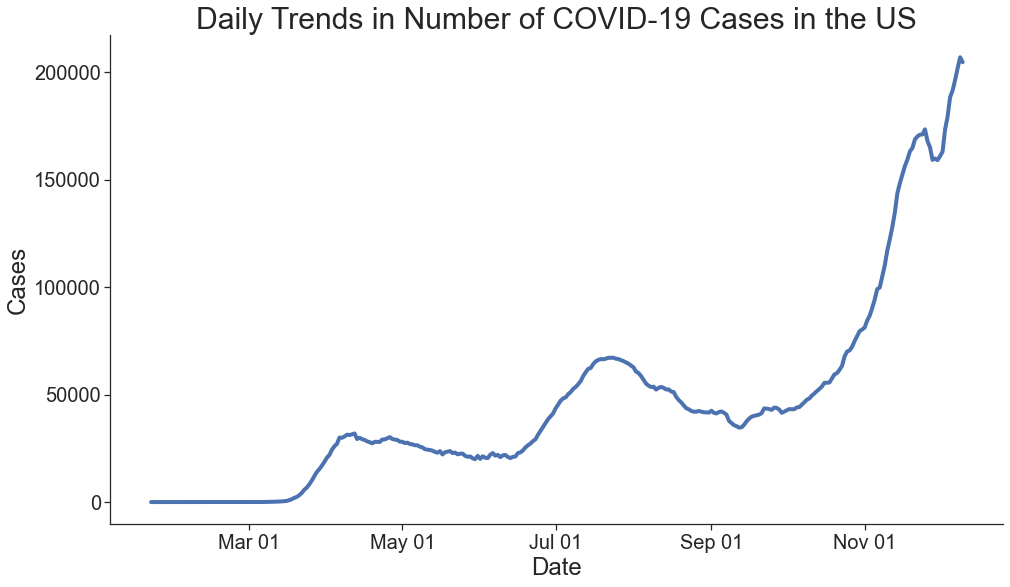

In [12]:
# plt.grid(b=None) # grid line
ax = sns.lineplot(data=covid_df, x='date', y='moving_avg', lw=4)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2)) # display every 2 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xlabel('Date')
plt.ylabel('Cases')
plt.title('Daily Trends in Number of COVID-19 Cases in the US')
plt.show()

In viewing the trend of COVID cases between January and December, we want to analyze if there is a similar trend in the negative sentiment towards Asian Americans in the tweets that we gathered. We notice that there are noticeably large peaks near the end of March, end of June, and end of September, meaning that there were heavy spikes in the amount of reported COVID cases in the U.S. When we retrieve and process the sentiment of our scraped tweets, we are looking for peaks in negative sentiment around these times as well. Additionally, we notice that the largest exponential trend was around the end of September.

#### Initial Model (TextBlob)

We first try to determine the sentiment of our tweets using an imported library, TextBlob, which then provides the means for common natural language processing and sentiment analysis through NLTK and test its accuracy on the prelabeled tweet data. We used this basic model because it was easy to extract the sentiment of any text.

In [13]:
tweet_dummy_df = prelabeled.copy() # deep copy so there's no reference to the original
tweet_dummy_df.reset_index(inplace=True, drop=True)
tweet_dummy_df

,Text,Label
0,@China_Amb_India Fucking piece of shit your wh...,Hate
1,Im not being funny but #Coronavirus in.... Chi...,Neutral
2,Got on the Victoria Line today to seven sister...,Hate
...,...,...
2316,"During this COVID19 crisis, @onlywon & I break...",Neutral
2317,Tune into @RadioCanadaInfo for stories from th...,Neutral
2318,Folks need to support and follow @becool2asian...,Counterhate


Below is the method used to convert TextBlob's sentiment polarity score on a piece of text to the classes of neutral, positive, or negative.

In [14]:
def blobConvert(text):
    test = TextBlob(text)
    if test.sentiment.polarity == 0:
        return 'Neutral'
    elif test.sentiment.polarity > 0:
        return 'Positive'
    else:
        return 'Negative'

Next, we apply the method on the tweet content and create a separate column for each tweet's predicted TextBlob sentiment.

In [15]:
tweet_dummy_df['Dumb Labels'] = tweet_dummy_df['Text'].apply(blobConvert)
tweet_dummy_df

,Text,Label,Dumb Labels
0,@China_Amb_India Fucking piece of shit your wh...,Hate,Negative
1,Im not being funny but #Coronavirus in.... Chi...,Neutral,Negative
2,Got on the Victoria Line today to seven sister...,Hate,Neutral
...,...,...,...
2316,"During this COVID19 crisis, @onlywon & I break...",Neutral,Negative
2317,Tune into @RadioCanadaInfo for stories from th...,Neutral,Neutral
2318,Folks need to support and follow @becool2asian...,Counterhate,Negative


Then, to compute the accuracy of the TextBlob analyzer, we wrote a method to compare the predicted labels to the actual hand-labelling done by researchers. We return a 1 if the predicted and actual labels match and a 0 otherwise. We save these values in new column named 'Accuracy'.

In [16]:
def computeAccuracy(df):
    if (df['Label'] == 'Neutral' and df['Dumb Labels'] == 'Neutral'):
        return 1
    elif ((df['Label'] == 'Hate' or df['Label'] == 'Non-Asian Aggression') and df['Dumb Labels'] == 'Negative'):
        return 1
    elif (df['Label'] == 'Counterhate' and df['Dumb Labels'] == 'Positive'):
        return 1
    else:
        return 0

tweet_dummy_df['Accuracy'] = tweet_dummy_df.apply(computeAccuracy, axis = 1)
tweet_dummy_df

,Text,Label,Dumb Labels,Accuracy
0,@China_Amb_India Fucking piece of shit your wh...,Hate,Negative,1
1,Im not being funny but #Coronavirus in.... Chi...,Neutral,Negative,0
2,Got on the Victoria Line today to seven sister...,Hate,Neutral,0
...,...,...,...,...
2316,"During this COVID19 crisis, @onlywon & I break...",Neutral,Negative,0
2317,Tune into @RadioCanadaInfo for stories from th...,Neutral,Neutral,1
2318,Folks need to support and follow @becool2asian...,Counterhate,Negative,0


By summing the 'Accuracy' column, we can see how many matches that we have between the predicted and actual sentiment labels for all of the tweets in the dataset. We divide this by the total number of observations to compute a percentage for how many tweets were correctly labeled.

In [17]:
sum = tweet_dummy_df['Accuracy'].sum()
accuracy = sum / len(tweet_dummy_df)
print('{:.2%} accuracy'.format(accuracy)) # convert to percentage, rounded 2 decimals

42.99% accuracy


The TextBlob sentiment analyzer was only able to produce a **~43%** accuracy on our prelabeled data. Furthermore, TextBlob cannot specifically detect negative sentiment towards Asian Americans in the context of COVID-19, but only negativity in general (though not completely accurate). In order to achieve a higher accuracy, we then trained an SVM after performing TF-IDF on our tweets to more accurately classify tweet sentiment.

#### SVM Model

We are using the same annotated dataset as before to train our SVM.

In [18]:
tweet_df = prelabeled
tweet_df.reset_index(inplace=True, drop=True)
tweet_df

,Text,Label
0,@China_Amb_India Fucking piece of shit your wh...,Hate
1,Im not being funny but #Coronavirus in.... Chi...,Neutral
2,Got on the Victoria Line today to seven sister...,Hate
...,...,...
2316,"During this COVID19 crisis, @onlywon & I break...",Neutral
2317,Tune into @RadioCanadaInfo for stories from th...,Neutral
2318,Folks need to support and follow @becool2asian...,Counterhate


However, upon trial, we found that training the SVM purely on the annotated dataset produced very low accuracy, due to the dataset being extremely skewed in favor of the number of observations of 'Neutral' tweets, because there was a much higher ratio of 'Neutral' tweets in comparison to any other classification of tweets. In order to counteract these effects, we used the undersampling method on our training data. The undersampling method takes number of observations of the minority class (the class with the least number of observations in the dataset) and takes a random sample of the same size of each of the other classes in the dataset. 

In [19]:
# getting cound and indices of class with smallest amount of samples
minority_class_len = len(tweet_df[tweet_df['Label'] == 'Non-Asian Aggression'])
minority_samples = tweet_df[tweet_df['Label'] == 'Non-Asian Aggression'].index

In [20]:
# taking random samples from each of the other classes, of the same size as the minority class
neutral_class_indices = tweet_df[tweet_df['Label'] == 'Neutral'].index
counterhate_class_indices = tweet_df[tweet_df['Label'] == 'Counterhate'].index
hate_class_indices = tweet_df[tweet_df['Label'] == 'Hate'].index
neutral_samples = np.random.choice(neutral_class_indices, minority_class_len, replace=False)
counterhate_samples = np.random.choice(counterhate_class_indices, minority_class_len, replace=False)
hate_samples = np.random.choice(hate_class_indices, minority_class_len, replace=False)

After undersampling, we are left with a dataframe that has an equal number of samples from each of the label classes and can more fairly train the SVM.

In [21]:
# concatenate the samples into a dataframe
under_sample_indices = np.concatenate([minority_samples, neutral_samples, counterhate_samples, hate_samples])
under_sample = tweet_df.loc[under_sample_indices]

In [22]:
under_sample['Label'].value_counts()

Non-Asian Aggression    321
Neutral                 321
Hate                    321
Counterhate             321
Name: Label, dtype: int64

Next, we have to convert each of the class labels into numerical values for the SVM classifier.

In [23]:
# Convert labels to numerical values
def convert_label(label):
     if label == 'Hate':
        return 2.0
     elif label == 'Non-Asian Aggression':
        return 1.0
     elif label == 'Neutral':
        return 0.0
     elif label == 'Counterhate':
        return -1.0
     else:
        return label

We must randomize the data to split it non-biasedly into training and test sets. We then apply the method to convert the labels into numerical values and save it into a new column. We will use this column to compute the accuracy of our model.

In [24]:
tweet_df = shuffle(under_sample) # randomize
tweet_df.reset_index(inplace=True, drop=True)
tweet_df['y'] = tweet_df['Label'].apply(convert_label)
tweet_df

,Text,Label,y
0,DHS has admitted allowing people coming here f...,Non-Asian Aggression,1.0
1,@trishankkarthik Who cares how the Chinese coo...,Non-Asian Aggression,1.0
2,"Inspired by recent events, Korean-Swedish arti...",Neutral,0.0
...,...,...,...
1281,@Ldw40920106 chink gook waverunner cunt eyes,Hate,2.0
1282,@StephenKing Many Asian friends have been the ...,Counterhate,-1.0
1283,Shoutout to all the fuck people saying Asians ...,Counterhate,-1.0


Next, we perform TF-IDF on the tweet contents to relatively weigh important words in our tweets. Out of the two natural language processing methods we learned in class, we chose to use TF-IDF over the Bag-Of-Words approach to better account for stop words.


In [25]:
# create vectorizer & specify parameters
tfidf = TfidfVectorizer(sublinear_tf=True, 
                        analyzer='word',   
                        max_features=2000,
                        tokenizer=word_tokenize,
                        stop_words = 'english')

tfidf_X = tfidf.fit_transform(tweet_df['Text']).toarray()
# get IDF to visuzlize
idf = tfidf.idf_
rr = dict(zip(tfidf.fit(tweet_df['Text']).get_feature_names(), idf))

token_weight = pd.DataFrame.from_dict(rr, orient='index').reset_index()
token_weight.columns=('token','weight')
token_weight = token_weight.sort_values(by='weight', ascending=False)

We can then split our model into the training and test sets. For our model, we decided to use an 80:20 ratio of training to test sample sizes after testing across multiple splits and found that it gave us the best accuracy of the common splits that we tried.

In [26]:
tfidf_Y = np.array(tweet_df['y'])
tfidf_train_X, tfidf_test_X, tfidf_train_Y, tfidf_test_Y = train_test_split(
     tfidf_X, tfidf_Y, test_size=0.20
)

Finally, we can train and fit our model and test it on the training set followed by the test set.

In [27]:
def train_SVM(X, Y, kernel='linear'):
    model = SVC(kernel=kernel, C=0.8, class_weight='balanced')
    model.fit(X, Y)
    return model

In [28]:
svm_model = train_SVM(tfidf_train_X, tfidf_train_Y)

In [29]:
df_predicted_train_Y = svm_model.predict(tfidf_train_X)
df_predicted_test_Y = svm_model.predict(tfidf_test_X)

In [30]:
# prediction on training set
print(classification_report(tfidf_train_Y, df_predicted_train_Y))

              precision    recall  f1-score   support

        -1.0       0.89      0.89      0.89       264
         0.0       0.93      0.82      0.87       251
         1.0       0.84      0.92      0.88       253
         2.0       0.91      0.92      0.91       259

    accuracy                           0.89      1027
   macro avg       0.89      0.89      0.89      1027
weighted avg       0.89      0.89      0.89      1027



On the training data, our model performed extremely well, with precisions averaging **89%** for each class as well as **89%** recall. However, high values are to be expected because we are predicting the labels for the same data that we trained on.

In [31]:
# prediction on test set
print(classification_report(tfidf_test_Y, df_predicted_test_Y))

              precision    recall  f1-score   support

        -1.0       0.62      0.72      0.67        57
         0.0       0.60      0.41      0.49        70
         1.0       0.47      0.60      0.53        68
         2.0       0.58      0.52      0.55        62

    accuracy                           0.56       257
   macro avg       0.57      0.56      0.56       257
weighted avg       0.57      0.56      0.55       257



On our test data, the model performed decently well, averaging **~50%** precision for each of the 4 classes. Although our model could be improved, we found that this was accuracy was pretty high, considering that we were trying to classify tweets into 4 different classes and would have expected to see about 25% accuracy for each class instead.

#### Testing on Scraped Tweets

After training our model, we then predict the sentiment of our scraped tweets. We save these values into a new column in the dataframe so we can easily see the predicted sentiment for each tweet.

In [33]:
# now to carry out tfidf on the actual scraped tweets dataframe
tfidf_scraped_tweets = tfidf.fit_transform(tpd['contents']).toarray()
df_predicted_scraped_tweets = svm_model.predict(tfidf_scraped_tweets)

tpd['sentiment'] = df_predicted_scraped_tweets
tpd

,id,created_at,contents,sentiment
0,1337185315811860481,2020-12-10 23:59:57+00:00,@senseimitch @JaniceTXBlessed @kimfreethinker ...,1.0
1,1337185312628465667,2020-12-10 23:59:56+00:00,I was talking with a friend today and he said ...,1.0
2,1337185302134353923,2020-12-10 23:59:54+00:00,@donwinslow @Yahoo There is a virus not a pand...,0.0
...,...,...,...,...
774045,1220057393133957123,2020-01-22 18:55:24+00:00,@danielmarven Hey I Dannie and rona re an le d...,1.0
774046,1220056585797611520,2020-01-22 18:52:12+00:00,@KagisoMathole3 Hahaha. I held on till the fin...,1.0
774047,1220056351377772544,2020-01-22 18:51:16+00:00,RONA S &#8211; XL Price: $ Link:,1.0


We then filter out the tweets that were classified with the sentiment value 2.0 which corresponds to the 'Hate' class, meaning hate towards Asian Americans.

In [34]:
# getting the tweets that was classified as negative/hate
hate_tweets = tpd[tpd['sentiment'] == 2.0]
hate_tweets.reset_index(drop=True, inplace=True)
hate_tweets

,id,created_at,contents,sentiment
0,1337185185759113216,2020-12-10 23:59:26+00:00,A North Little Rock state representative has t...,2.0
1,1337185096286277633,2020-12-10 23:59:05+00:00,We spend a lot of time on our electronic devic...,2.0
2,1337185050123784192,2020-12-10 23:58:54+00:00,I think Im going to get the vaccine before the...,2.0
...,...,...,...,...
29825,1220096606508388352,2020-01-22 21:31:13+00:00,"Hypocrisy: Vindu,kamya,etc all was justifying ...",2.0
29826,1220081878427848706,2020-01-22 20:32:42+00:00,Cheap tactics! Shukla isse aapki soch aur gand...,2.0
29827,1220067559321604098,2020-01-22 19:35:48+00:00,@bcruz_1 Your name is Brandoob Cruz youre a 21...,2.0


We removed the time from the date format in the 'created_at' column to make it more apparent which tweets came from which date.

In [35]:
hate_tweets['created_at'] = pd.to_datetime(hate_tweets['created_at']).dt.date
hate_tweets['created_at'].value_counts()

2020-06-26    160
2020-01-24    134
2020-05-24    132
             ... 
2020-02-06     49
2020-02-05     44
2020-10-27     41
Name: created_at, Length: 324, dtype: int64

We convert the occurrences of 'Hate' tweets into a dataframe, with the rows aggregated by date to get the total number of predicted hate tweets for each day, and then sort the observations in ascending order of the 'date' column for processing.

In [36]:
# convert the series to a dataframe
date_data = []
for date, numTweets in hate_tweets['created_at'].value_counts().iteritems():
    date_data.append([date, numTweets])

avg_df = pd.DataFrame(date_data, columns=['date', 'hate_count'])

# sort by earliest date
avg_df['date'] = pd.to_datetime(avg_df['date'])
avg_df.sort_values(by='date', inplace=True)
avg_df.reset_index(drop=True, inplace=True)

avg_df

,date,hate_count
0,2020-01-22,84
1,2020-01-23,85
2,2020-01-24,134
...,...,...
321,2020-12-08,92
322,2020-12-09,82
323,2020-12-10,88


Below, we calculate the 7-day moving average of the number of predicted hate tweets in correspondence with the COVID-19 daily trends graph. After plotting, we can then analyze if there are any similarities in trends between the moving average of predicted negative sentiment and the moving average of COVID-19 cases.

In [37]:
# calculate moving average of 7 days
avg_df['average'] = avg_df['hate_count'].rolling(window=7).mean()
avg_df

,date,hate_count,average
0,2020-01-22,84,NaN
1,2020-01-23,85,NaN
2,2020-01-24,134,NaN
...,...,...,...
321,2020-12-08,92,90.29
322,2020-12-09,82,88.71
323,2020-12-10,88,89.57


Since we're calculating the moving average of 7 days, the first 6 days in the data frame will not have an average, thus we can drop it from the frame.

In [38]:
# since the first 6 days won't have a moving average, we can't use it for the graph
avg_df = avg_df[pd.notnull(avg_df['average'])]
avg_df.reset_index(drop=True, inplace=True)

avg_df

,date,hate_count,average
0,2020-01-28,104,90.00
1,2020-01-29,94,91.43
2,2020-01-30,72,89.57
...,...,...,...
315,2020-12-08,92,90.29
316,2020-12-09,82,88.71
317,2020-12-10,88,89.57


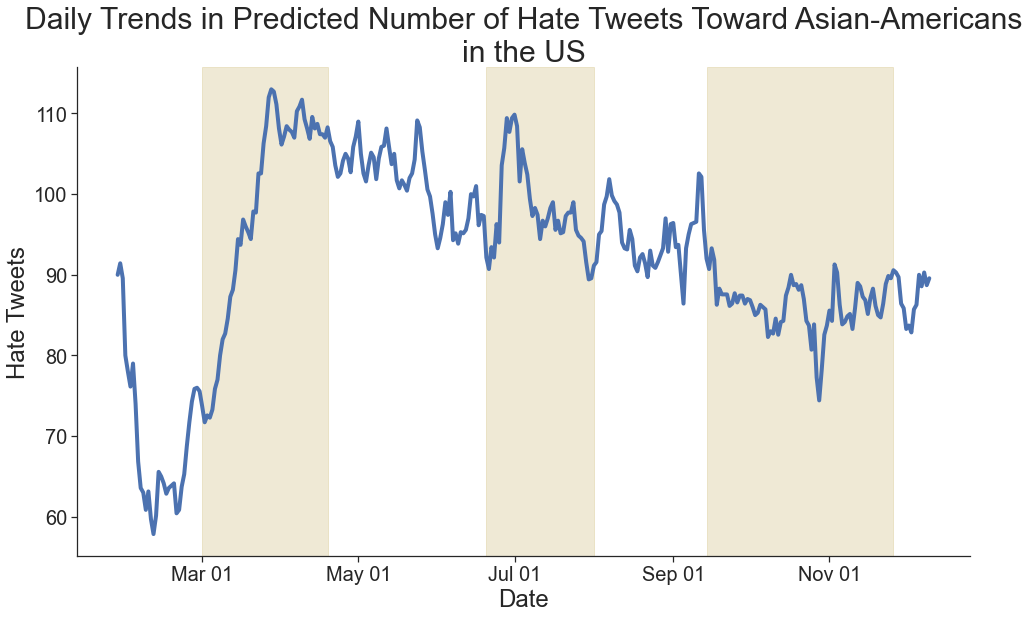

In [39]:
# plt.grid(b=None) # grid line
ax = sns.lineplot(data=avg_df, x='date', y='average', lw=4)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2)) # display every 2 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xlabel('Date')
plt.ylabel('Hate Tweets')
plt.title('\n'.join(wrap('Daily Trends in Predicted Number of Hate Tweets Toward Asian-Americans in the US')))

# highlight the peaks of covid cases into this graph
plt.axvspan('2020-03-01', '2020-04-19', alpha=0.3, color='y')
plt.axvspan('2020-06-20', '2020-08-01', alpha=0.3, color='y')
plt.axvspan('2020-09-14', '2020-11-26', alpha=0.3, color='y')
plt.show()

This graph depicts our model's predictions of how many hate tweets there are in a given day. The **highlighted** areas are where the daily trends in the amount of U.S. COVID-19 cases spiked. The first two highlighted regions are in line with our hypothesis; with a peak in COVID-19 cases, we can see that our model predicts an increase in the amount of anti-Asian tweets. However, our model predicts that there is no spike in the last highlighted region, contrasting the last two surges in COVID-19 cases. This suggests one of two things: the first being the model isn't entirely accurate. This could be due to the training set being too small (1200 tweets) for the amount of tweets that were scraped (~700k tweets). The second reason the model doesn't predict a spike in hate tweets here is due to the possiblity of the American mindset changing. The fluctuation of hate tweets over the last highlighted region suggests a shift in the American mindset about who to blame for COVID-19.

Next, we want to calculate which of the keywords that we searched for was most prevalent in our scraped tweets. Below, we calculate the number of occurrences of each keyword.

In [40]:
occurrences = {} # we want to see how many times were each keyword used

# initialize our dictionary
for word in keywords:
    occurrences[word] = 0

# iterate through every row to check tweet for any occurrences
for i in range(len(hate_tweets)):
    content = hate_tweets.loc[i]['contents']
    words = content.split()
    
    # check if any of the keywords were used
    for word in keywords:
        if word in words:
            occurrences[word] += 1

# we need to account for keywords that are two words as well
for i in range(len(hate_tweets)):
    content = hate_tweets.loc[i]['contents']
    words = content.split()
    grouped_words = [' '.join(words[i: i + 2]) for i in range(0, len(words), 2)]
    
    for word in keywords:
        if len(word.split()) == 2:
            if word in grouped_words:
                occurrences[word] += 1
                
occurrences

{'virus': 4965,
 'covid': 854,
 'chinese virus': 67,
 'quarantine': 7382,
 'rona': 1280}

Next, we convert the number of occurrences for each keyword into a dataframe for plotting purposes.

In [41]:
# convert our dictionary to a dataframe
frequent_data = []
for keyword, numTweets in occurrences.items():
    frequent_data.append([keyword, numTweets])

frequent_df = pd.DataFrame(frequent_data, columns=['keyword', 'occurrences'])
frequent_df.sort_values(by='occurrences', inplace=True, ascending=False)
frequent_df.reset_index(drop=True, inplace=True)

frequent_df

,keyword,occurrences
0,quarantine,7382
1,virus,4965
2,rona,1280
3,covid,854
4,chinese virus,67


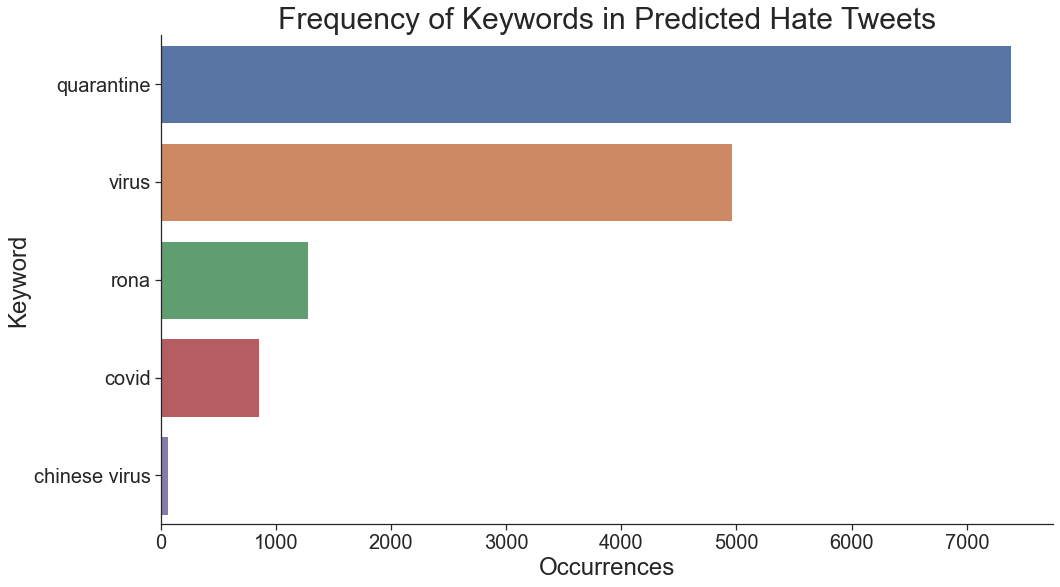

In [42]:
# plt.grid(b=None) # grid line
ax = sns.barplot(data=frequent_df, x='occurrences', y='keyword')
plt.xlabel('Occurrences')
plt.ylabel('Keyword')
plt.title('Frequency of Keywords in Predicted Hate Tweets')

plt.show()

This visualization explicitly shows that the foremost keyword 'quarantine' had the most occurrences. Our model suggests that Americans may be projecting their dislike towards quarantine onto the Asian American community. Secondly, the next highest keywords of 'virus', 'rona', 'covid' could suggest Americans projecting their anxiety towards coronavirus onto the Asian American community.

# Ethics & Privacy

This project uses publicly available data by scraping from the social media site Twitter. While there may be privacy concerns in terms of revealing personally identifiable information such as account names and other background information from users' biographies, those with public accounts have already consented to and made aware of within the social media' terms and conditions.

Scraping tweets may be potentially biased in that social media sites often feature the most popular posts from the most interacted with accounts first, which may skew the data towards more popular, radicalized perspectives. These tweets may include racially charged sentiment with high numbers of engagements, causing increased measures of negativity and hate to be interpreted in the analysis. Additionally, the keywords that were used in searching for specific tweets to scrape from Twitter are originally referenced from a reputable source as to avoid subjectivity in the tweets that are analyzed. We have cited the articles we used in finding these keywords. Because we are specifically analyzing negative tweets, we knew that our data would involve sensitive and radical language. In the event that our scraped tweets show an inverse relationship (shows positive sentiment), it may involve Twitter’s role in “hiding” or deleting sensitive and flagged tweets.

Finally, the intended purpose of this analysis is not to highlight or favor a single demographic but rather to perform general case study, as all groups—regardless of race—are impacted by COVID-19. In the event that our data portrays a great deal of racially negative comments, we recognize that this can cause more harmful effects towards not only Asian but all communities. This can be harmful because these negative tweets can shape one’s perspective towards another community and culture,  consequently creating implicit biases and stereotypes.  However, this is not what we intend for. We hope that this analysis could potentially and directly benefit the Twitter community and social media users in general as it would shed light on the harmful effects of racially charged sentiments. Consequently, this could make Twitter users more cognizant of how their words could be hurtful to a minority group and help spread their awareness to others. 


# Conclusion

### Question: What is the relationship between the rise of COVID-19 cases in the U.S. during the pandemic and the increase of negative sentiment towards the Asian-American community on Twitter in the form of content and keywords?

After an analysis of our model, there seems to not be a clear relationship between the rise of COVID-19 cases and the increase of negative sentiment towards the Asian-American community.

Though we hypothesized that an increase in COVID cases would be correlated with an increase in negative sentiment towards Asian Americans on Twitter, we were surprised to see a large variance in tweet sentiment during the pandemic, even though negativity towards Asians seemed to be spotlighted in media.

### Limitations

Our project has many limitations. This includes the inaccuracy of our model due to the size of our training data and that we used a linear kernel when the data may not be linearly classifiable. Furthermore, TF-IDF may have actually reduced the accuracy of our model because we scraped tweets based on certain keywords, meaning that they might have had higher frequency than other stopwords and be weighted less due to the inverse document frequency. In addition, due to limitiations in time it takes to scrape and computing power, our analysis is not entirely accurate because we only scraped ~500 tweets per day, with 5 keywords as our query, when in fact millions are posted a day. Thus, we have most likely not captured the actual overall sentiment of all tweets during the pandemic.



### Final Thoughts

Overall, we were not able to find a correlation between the rise of COVID-19 cases and the increase of negative sentiment towards the Asian-American community. Despite our findings, it is still important to realize the role social media has on the racialization of not only Asian Americans, but for any group of people. We realized that scraping and training a model to analyze sentiment was more complicated than we hypothesized and we hope that our attempted analysis can help others in developing a better model to analyze anti-Asian sentiment on Twitter and other social media platforms.



# Team Contributions

Jeffrey Ha
- Tweet Scraping
- Data Visualization

David Ma
- Research Question
- Tweet Scraping
- Visualization Analysis
- Model Application

Mary Nguyen
- Model Training & Analysis
- EDA

Jason Win
- Model Application
- Tweet Scraping

Sidi Xu
- Model Training & Analysis
- Visualization Analysis
- EDA